In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [4]:
def fst(lst): return [ele[0] for ele in lst ];
def snd(lst): return [ele[1] for ele in lst ];

In [5]:
def ratio(x,mu1=0.,mu2 = 1.,sigma=3): #Gaussian Log-likelihood ratio
    return ((mu2 - mu1)/(2*sigma))*(2*x - (mu1 + mu2))

Define several change detectors

In [6]:
def cusum_generator(seq): #
    z = 0.
    for x in seq:
        z = max(0, z + ratio(x))
        yield z

In [7]:
def window_generator(seq,w_len = 5): # Finite Moving Average. w_len=1 means use current only
    z = 0.
    history=np.zeros(w_len)
    for x in seq:
        z -= history[0]
        
        history = np.roll(history,-1)
        
        history[-1] = ratio(x)
        
        z += history[-1]
        
        yield z

In [8]:
def window(w_len):
    return (lambda seq : window_generator(seq,w_len))

In [9]:
def dynamic_window_statistic(x): # Dynamic window. Equivalent to CUSUM
    m = len(x)
    z_seq = []
    

    mS = 0
    S = 0
    w =0
    
    #wszs = []
    for i in range(0, m):
        # Calculate new window
        S = S + ratio(x[i])
        if S < mS:
            w = i
            mS = S
            
        # Sum over window.
        z = 0 
        for j in range(w,i+1):
            z = z + ratio(x[j])
            
        #wszs.append(i+1-w)    
        z_seq.append(z)
        
    #plt.plot(wszs[475:525])
    return np.array(z_seq)

In [10]:
def geom_generator(seq,alpha=9/10.): # Geometric Moving Average
    z = 0.
    for x in seq:
        z = (1-alpha)*z + alpha*ratio(x)
        yield z

In [11]:
# Function to generate a random sequence.
# The sequence may or may not have a change point,
# (mu1,sigma1) are the distribution parameters before the change,
# (mu2,sigma2) are the parameters after the change.
def sequence_generator(length, 
                       mu1 = 0, sigma1 = 3, 
                       change_point=None, 
                       mu2=1 ,sigma2 = 3,
                       seed = None): #ret[change_point] = 1st new pt 

    if seed is None: 
        seed =  random.randrange(2**32 -1 )
    np.random.seed(seed)
    print("Seed was:", seed)
    
    if change_point == None: change_point = length
    i=0;
    while i < length:
        if i < change_point:
            yield sigma1*np.random.randn() + mu1
        else:
            yield sigma2*np.random.randn() + mu2
        i = i + 1

In [12]:
a_seq = list( sequence_generator(length = 1000,change_point = 500)) # signal|

('Seed was:', 1875883048)


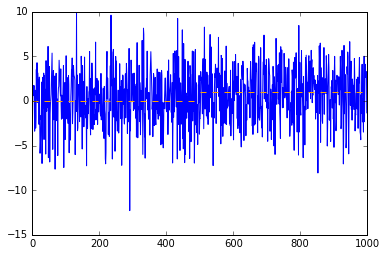

In [13]:
plt.plot( a_seq ); 
plt.plot((0,500),(0,0),'--',color='orange',); 
plt.plot((500,1000),(1,1),'--',color='orange')

In [14]:
cz = list( cusum_generator(a_seq) );

wz5 = list( window(5)(a_seq) );

wz25 = list( window(25)(a_seq))

gz = list( geom_generator(a_seq) );

dz = dynamic_window_statistic(a_seq)

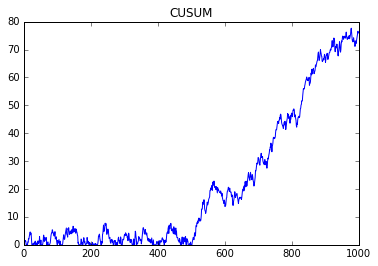

In [15]:
plt.plot( cz ); plt.title("CUSUM");

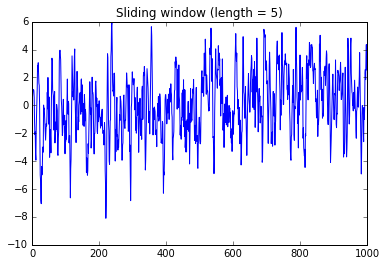

In [16]:
plt.plot( wz5 ); plt.title("Sliding window (length = 5)");

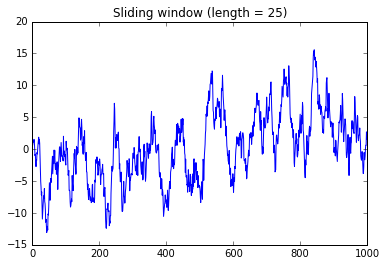

In [17]:
plt.plot( wz25 ); plt.title("Sliding window (length = 25)");

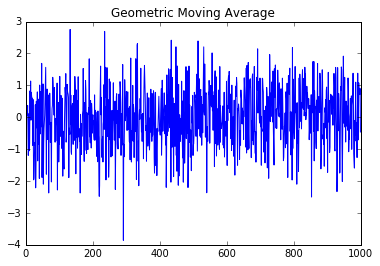

In [18]:
plt.plot(gz); plt.title("Geometric Moving Average");

In [19]:
#plt.plot(dz); plt.title("Dynamic Sliding Window");

In [20]:
def detect_time(seq,h,startpt=0):
    i = 0
    the_seq = []
    for x in seq:
        the_seq.append(x)
        if x >= h and i >= startpt:
            return (i,the_seq)
        i = i + 1
    return (np.infty,the_seq)

('Seed was:', 3922678904)
Window time: inf 
CUSUM time: inf 
Window time: inf 
CUSUM time: inf 


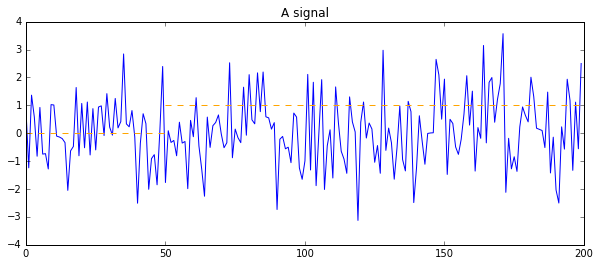

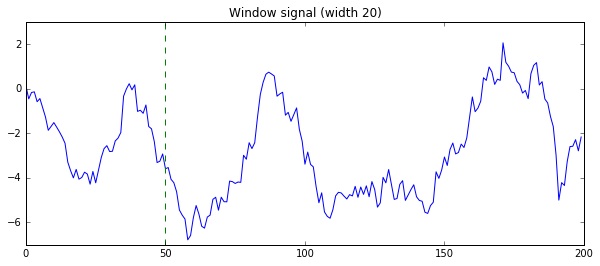

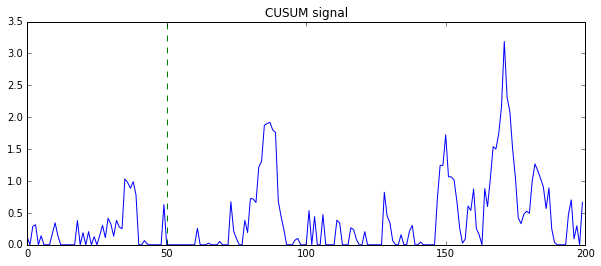

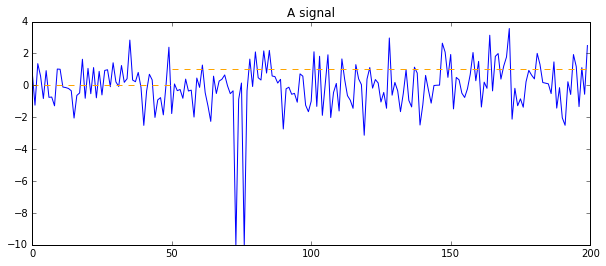

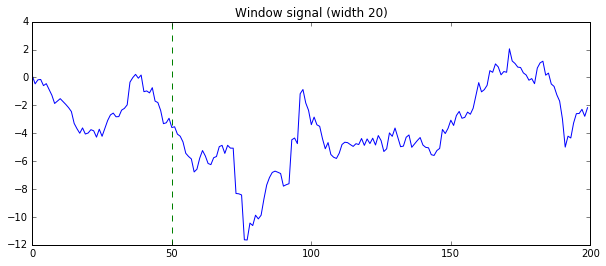

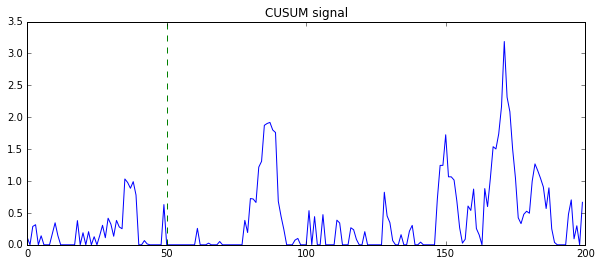

In [39]:
#How does window = 25 do on an example sequence?

a_seq = list( sequence_generator(length = 200,mu1=0, mu2=0,sigma1=1,sigma2=1.5,
                                 change_point = 50,
                                 seed =None )) # signal|

def investigate(a_seq):
    plt.figure()
    plt.plot(a_seq);
    plt.plot((0,50),(0,0),'--',color='orange',); 
    plt.plot((50,200),(1,1),'--',color='orange')
    plt.title("A signal");

    wz20 = list( window(20)(a_seq))
    plt.rcParams["figure.figsize"] =(10,4)
    dtime = detect_time(wz20,h=7.278)[0]; print("Window time: %f " % dtime)

    plt.figure()
    plt.plot(wz20); 
    plt.axvline(50,color='g', linewidth=1,linestyle='--'); 
    plt.axvline(dtime,color='r', linewidth=2,linestyle='--');
    plt.title("Window signal (width 20)")
    #How does CUSUM do on our example sequence?

    cz = list( cusum_generator(a_seq))

    dtime = detect_time(cz,h=9.254)[0]; print("CUSUM time: %f " % dtime)
    plt.figure();
    plt.plot(cz); 
    plt.axvline(50,color='g', linewidth=1,linestyle='--'); 
    plt.axvline(dtime,color='r', linewidth=2,linestyle='--');
    plt.title("CUSUM signal");
    
# Seed 365669385 good for impact on delay. (cusum h 9.25 window h 8) a[59] -20
# Seed 1791404929 another good one.
# Seed 1574010301 good.
investigate(a_seq)
a_seq[73] = -10
a_seq[76] = -10
investigate(a_seq)


In [22]:
#estimate false alarms/delays at a particular threshold.
def false_alarms_and_delays(h, statistic = cusum_generator, n = 1000, seed = None, cpt = 0):
    if seed is not None: np.random.seed(seed)
        
    # delay: how long it takes to detect when change happens at time 0.
    ds = []
    for i in range(n):
        x = sequence_generator(length=np.infty,change_point = cpt)
        z = statistic(x)
        t = detect_time(z,h,startpt=0)
        
        if(t[0] >= cpt):
            ds.append(t[0] - cpt)
    
    d = np.mean(ds)
    #print("ds size: %d n: %d" % (len(ds),n))

    #false alarm: how long until change is detected when there isn't one.
    fs = [] 
    for i in range(n):
        x = sequence_generator(length = np.infty,change_point = None)
        z = statistic(x)
        t = detect_time(z,h)
        fs.append(t[0])
            
    f = np.mean(fs)
    print("Using h = %f yielded time-to-false-alarm of %f and delay average of %f" % (h,f,d) )
    #print(fs)
    return (f,d)

In [23]:
def solve_for_ttfa(statistic):
    h = 1
    (delay, ttfa) = (None,None)
    while ttfa < 200:
        h = h + 0.1
        (ttfa,delay) = false_alarms_and_delays(h,statistic,cpt=50,n=30000)
    print("using h = %f yields ttfa %f and delay %f " % (h,ttfa,delay))

In [24]:
# time solve_for_ttfa(window(5))

In [25]:
# solve_for_ttfa(window(10))

In [26]:
# solve_for_ttfa(window(15))

In [27]:
# solve_for_ttfa(window(20))

In [28]:
# solve_for_ttfa(window(25))

In [29]:
# solve_for_ttfa(window(30))

In [30]:
# solve_for_ttfa(window(35))

In [31]:
# solve_for_ttfa(window(40))

In [32]:
# solve_for_ttfa(cusum_generator)

In [33]:
w1 = np.loadtxt("w1.csv",delimiter=',')[:,[1,2]]
w5 = np.loadtxt("w5.csv",delimiter=',')[:,[1,2]]
w10 = np.loadtxt("w10.csv",delimiter=',')[:,[1,2]]
w15 = np.loadtxt("w15.csv",delimiter=',')[:,[1,2]]
w20 = np.loadtxt("w20.csv",delimiter=',')[:,[1,2]]
w40 = np.loadtxt("w40.csv",delimiter=',')[:,[1,2]]
wc = np.loadtxt("c.csv",delimiter=',')[:,[1,2]]

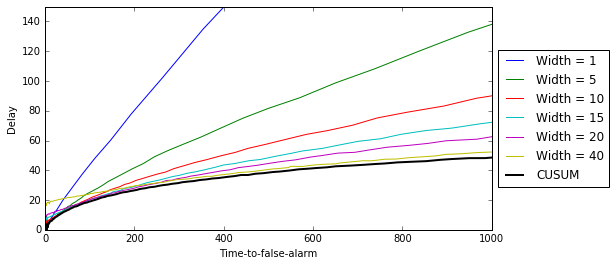

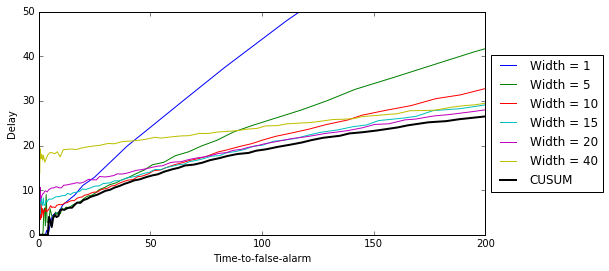

In [34]:
#plt.plot( fst(w1), snd(w1), label = "Width = 1" ); 
def do_plots():
    plt.plot( fst(w1), snd(w1), label = "Width = 1" ); 
    plt.plot( fst(w5), snd(w5), label = "Width = 5" );
    plt.plot( fst(w10), snd(w10), label = "Width = 10" );
    plt.plot( fst(w15), snd(w15), label = "Width = 15" );
    plt.plot( fst(w20), snd(w20), label = "Width = 20" );
    plt.plot( fst(w40), snd(w40), label = "Width = 40" );
    plt.plot( fst(wc), snd(wc), label = "CUSUM" , color='black', linewidth=2);

plt.rcParams["figure.figsize"] =(10,4)
do_plots()
plt.ylim(ymin=0,ymax = 150)
plt.xlim(xmin = 0, xmax=1000);
plt.xlabel("Time-to-false-alarm");
plt.ylabel("Delay");
# Put a legend to the right of the current axis
ax = plt.gca();
box = ax.get_position();
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

plt.rcParams["figure.figsize"] =(10,4)
plt.figure();
do_plots()
plt.ylim(ymin=0,ymax=50)
plt.xlim(xmin =0 ,xmax=200);
plt.xlabel("Time-to-false-alarm");
plt.ylabel("Delay");

# Put a legend to the right of the current axis
ax = plt.gca();
box = ax.get_position();
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

('Seed was:', 1392728426)
Window time: 162.000000 
CUSUM time: 164.000000 


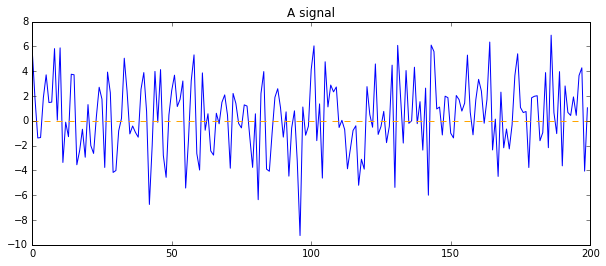

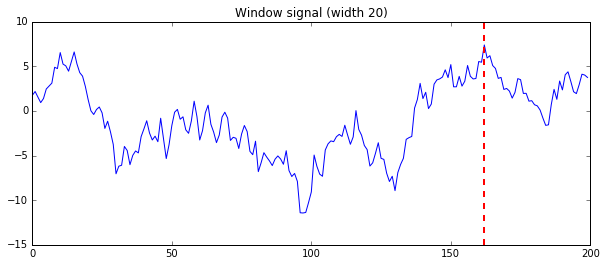

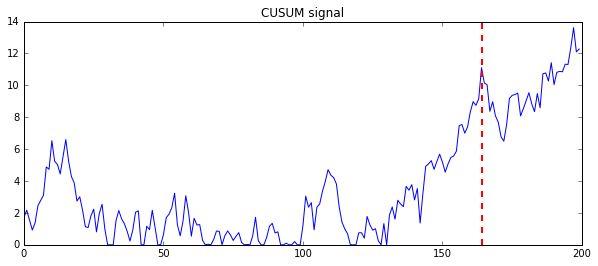

In [37]:
#How does window = 25 do on an example sequence?

a_seq = list( sequence_generator(length = 200,
                                 change_point = None,
                                 seed =None )) # signal|

def investigate(a_seq):
    plt.figure()
    plt.plot(a_seq);
    plt.plot((0,200),(0,0),'--',color='orange',); 
    plt.title("A signal");

    wz20 = list( window(20)(a_seq))
    plt.rcParams["figure.figsize"] =(10,4)
    dtime = detect_time(wz20,h=7.278)[0]; print("Window time: %f " % dtime)

    plt.figure()
    plt.plot(wz20); 
    plt.axvline(dtime,color='r', linewidth=2,linestyle='--');
    plt.title("Window signal (width 20)")
    #How does CUSUM do on our example sequence?

    cz = list( cusum_generator(a_seq))

    dtime = detect_time(cz,h=9.254)[0]; print("CUSUM time: %f " % dtime)
    plt.figure();
    plt.plot(cz); 
    plt.axvline(dtime,color='r', linewidth=2,linestyle='--');
    plt.title("CUSUM signal");
    
# Seed 365669385 good for impact on delay. (cusum h 9.25 window h 8) a[59] -20
# Seed 1791404929 another good one.
# Seed 1574010301 good.
investigate(a_seq)

